In [1]:
from abc import ABC, abstractmethod
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
BANDIT_REWARD = [1, 2, 3, 4]
NUMBER_OF_TRIALS = 20000
EPS = 0.1

In [3]:
class Bandit(ABC):

    @abstractmethod
    def __init__(self, reward):
        self.reward = reward

    @abstractmethod
    def __repr__(self):
        pass

    @abstractmethod
    def pull(self):
        pass

    @abstractmethod
    def update(self):
        pass

    @abstractmethod
    def experiment(self):
        pass

    @abstractmethod
    def plot_learning_process(self): 
        pass

    @abstractmethod
    def report(self):
        pass

# Epsilon Greedy

In [4]:
class EpsilonGreedy(Bandit):
    """
    An implementation of the Epsilon Greedy algorithm for multi-armed bandit problems.

    Inherits from the Bandit class.
    """
    
    def __init__(self, reward):
        """
        Constructor for the EpsilonGreedy class.
        """
        self.reward = reward
        self.reward_estimate = 0
        self.N = 0
    
    def __repr__(self):
        """
        String representation of the class.
        """
        return f'A Bandit with {self.reward} Reward'
    
    def pull(self):
        """
        Pulls the arm of the bandit and generate a random reward.
        """
        return np.random.randn() + self.reward
    
    def update(self, x):
        """
        Updates the reward estimate based on the current reward obtained.
        """
        self.N += 1
        self.reward_estimate = (1 - 1.0/self.N) * self.reward_estimate + 1.0/ self.N * x

    def experiment(self, bandit_rewards, t, N):
        """
        Runs the Epsilon Greedy algorithm on a set of bandits.
        """
        bandits = [EpsilonGreedy(reward) for reward in bandit_rewards]
        
        num_times_explored = 0
        num_times_exploited = 0
        num_optimal = 0
        optimal_j = np.argmax([b.reward for b in bandits])
        print(f'optimal bandit index: {optimal_j}')
        
        # empty array to later add the rewards for inference plots
        eg_rewards = np.empty(N)
        eg_selected_bandit = []
        eps = 1/t

        for i in range(N):
            #generating a random number 
            p = np.random.random() 
            
            # if the random number is smaller than eps we explore a random bandit
            if p < eps:  
                num_times_explored += 1
                j = np.random.choice(len(bandits)) 
            else:
                # if the random number is bigger than eps we explore the bandit with the highest current reward
                num_times_exploited += 1
                j = np.argmax([b.reward_estimate for b in bandits])
            
            # pull the chosen bandit and get the output
            x = bandits[j].pull()
            
            # increases N by 1 and calculates the estimate of the reward
            bandits[j].update(x) 
            
            # if j is the actual optimal bandit, the optimal bandit count increments by 1
            if j == optimal_j:
                num_optimal += 1
            
            # add the selected bandit to the list of selected bandits
            eg_selected_bandit.append(j)
            
            # add the reward to the data
            eg_rewards[i] = x
            
            # increase t, i.e., decrease the probability of choosing suboptimal (random) bandit
            t += 1
            eps = 1/t
        
        estimated_avg_rewards=[round(b.reward_estimate, 3) for b in bandits]
        print(f'Estimated average reward where epsilon= {eps}:---{estimated_avg_rewards}')
        
        all_bandits = pd.DataFrame({"Bandit" : eg_selected_bandit, "Reward" : eg_rewards, "Algorithm" : "Epsilon Greedy"})
        all_bandits.to_csv("./csv/EpsilonGreedy_All.csv", index=False)
        
        return bandits, eg_rewards, num_times_explored, num_times_exploited, num_optimal
    
    def plot_learning_process(self, bandit_rewards, eg_rewards, N):
        """
        Plots the win rate and optimal win rate against the number of trials.
        """        
        cumulative_rewards = np.cumsum(eg_rewards)
        win_rates = cumulative_rewards / (np.arange(N) + 1)
        
        plt.figure(figsize=(10, 8))
        plt.plot(win_rates, label="Win Rate")
        plt.plot(np.ones(N)*np.max(bandit_rewards), label='Optimal Win Rate')
        plt.legend()
        plt.title("Win Rate Convergence Epsilon-Greedy")
        plt.xlabel("Number of Trials")
        plt.ylabel("Average Reward")
        plt.show()

    def report(self, bandits, eg_rewards, num_times_explored, num_times_exploited, num_optimal, N):
        """
        Creates a report with statistics such as mean estimates, total reward earned,
        and the number of times a bandit was explored or exploited, and saves the output in a csv file.
        """
        df = pd.DataFrame()
        for i, b in enumerate(bandits):
            print(f"Bandit {i} Mean Estimate: {b.reward_estimate :.4f}")
            df["Bandit"] = [b for b in bandits]
            df["Reward"] = [b.reward_estimate for b in bandits]
            df["Algorithm"] = "EpsilonGreedy"
    
        print(f"\nTotal Reward Earned: {eg_rewards.sum()}")
        print(f"Average Reward: {np.mean(eg_rewards)}")
        print(f"Overall Win Rate: {eg_rewards.sum() / N :.4f}\n")
        print(f"# of explored: {num_times_explored}")
        print(f"# of exploited: {num_times_exploited}")
        print(f"# of times selected the optimal bandit: {num_optimal}")
        
        df.to_csv("./csv/EpsilonGreedy_Last.csv", index=False)
        
        return df

In [5]:
EG = EpsilonGreedy(Bandit)

In [6]:
bandits, eg_rewards, num_times_explored, num_times_exploited, num_optimal = EG.experiment(BANDIT_REWARD, 10, N=NUMBER_OF_TRIALS) # t=10 -> eps = 1/t = 0.1

optimal bandit index: 3
Estimated average reward where epsilon= 4.9975012493753125e-05:---[0.755, 1.905, 2.882, 3.994]


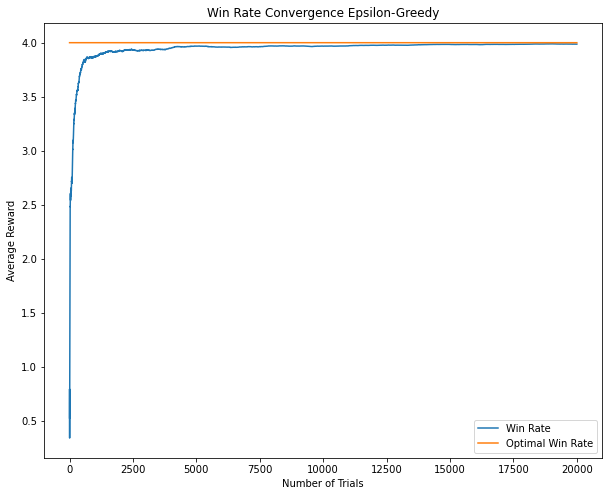

In [7]:
EG.plot_learning_process(BANDIT_REWARD, eg_rewards, N=NUMBER_OF_TRIALS)

In [8]:
df = EG.report(bandits, eg_rewards, num_times_explored, num_times_exploited, num_optimal, N=NUMBER_OF_TRIALS)

Bandit 0 Mean Estimate: 0.7547
Bandit 1 Mean Estimate: 1.9052
Bandit 2 Mean Estimate: 2.8816
Bandit 3 Mean Estimate: 3.9935

Total Reward Earned: 79731.69042334048
Average Reward: 3.986584521167024
Overall Win Rate: 3.9866

# of explored: 10
# of exploited: 19990
# of times selected the optimal bandit: 19891


# Thompson Sampling

In [9]:
class ThompsonSampling(Bandit):
    """
    An implementation of the Thompson Sampling algorithm for multi-armed bandit problems.

    Inherits from the Bandit class.
    """
    
    def __init__(self, true_mean):
        """
        Constructor for the ThompsonSampling class.
        """
        self.true_mean = true_mean
        self.m = 0
        self.lambda_ = 1
        self.tau = 1
        self.N = 0
        self.sum_x = 0
        
    def __repr__(self):
        """
        String representation of the class.
        """
        return f"A Bandit with {self.true_mean} Win Rate"

    def pull(self):
        """
        Samples a reward from the bandit using its true mean.
        """
        return np.random.randn() / np.sqrt(self.tau) + self.true_mean

    def sample(self):
        """
        Samples a reward from the bandit using its posterior mean.
        """
        return np.random.randn() / np.sqrt(self.lambda_) + self.m

    def update(self, x):
        """
        Updates the bandit's posterior mean and precision using the reward received.
        """
        self.m = (self.tau * x + self.lambda_ * self.m) / (self.tau + self.lambda_)
        self.lambda_ += self.tau
        self.N += 1
    
    def experiment(self, bandit_rewards, N):
        """
        Runs the Thompson Sampling algorithm on a set of bandits.
        """
        bandits = [ThompsonSampling(m) for m in bandit_rewards]
        
        sample_points = [100, 1000, 2000, 5000, 10000, 19999]
        
        # empty array to later add the rewards for inference plots
        t_rewards = np.empty(N)
        t_selected_bandit = []
        
        for i in range(N):
            j = np.argmax([b.sample() for b in bandits]) #taking the highest mean position
            
            # make some plots
            if i in sample_points:
                self.plot_bandit_distributions(bandits, i)
            
            # pull the chosen bandit and get the output
            x = bandits[j].pull()

            # increases N by 1, updates lambda and calculates the estimate of the m
            bandits[j].update(x)
            
            # add the reward to the data
            t_rewards[i] = x
            
            # Add the selected bandit to the list
            t_selected_bandit.append(j)
        
        all_bandits = pd.DataFrame({"Bandit" : t_selected_bandit, "Reward" : t_rewards, "Algorithm" : "Thompson Sampling"})
        all_bandits.to_csv("./csv/ThompsonSampling_All.csv", index=False)

        return bandits, t_rewards
    
    def plot_learning_process(self, bandit_rewards, t_rewards, N):
        """
        Plots the win rate and optimal win rate against the number of trials.
        """
        cumulative_rewards = np.cumsum(t_rewards)
        win_rates = cumulative_rewards / (np.arange(N) + 1)
        
        plt.figure(figsize=(10, 8))
        plt.plot(win_rates, label="Win Rate")
        plt.plot(np.ones(N)*np.max(bandit_rewards), label='Optimal Win Rate')
        plt.legend()
        plt.title("Win Rate Convergence Thompson Sampling")
        plt.xlabel("Number of Trials")
        plt.ylabel("Average Reward")
        plt.show()

    def plot_bandit_distributions(self, bandits, trial):
        """
        Plots the distribution of each bandit after a given number of trials.
        """
        x = np.linspace(-3, 6, 200)
        for b in bandits:
            y = norm.pdf(x, b.m, np.sqrt(1. / b.lambda_))
            plt.plot(x, y, label = f"real mean: {b.true_mean:.4f}, num plays: {b.N}")
            plt.title(f"Bandit distributions after {trial} trials")
        plt.legend()
        plt.show()
        
    def report(self, bandits, t_rewards, N):
        """
        Creates a report with statistics such as total reward earned, average reward,
        and the overall win rate, and saves the output in a csv file.
        """
        df = pd.DataFrame()
        for b in bandits:
            df["Bandit"] = [b for b in bandits]
            df["Reward"] = [b.m for b in bandits]
            df["Algorithm"] = "ThompsonSampling"
        
        print(f"Total Reward Earned: {t_rewards.sum()}")
        print(f"Average Reward: {np.mean(t_rewards)}")
        print(f"Overall Win Rate: {t_rewards.sum() / N}")
        print(f"Number of times selected each bandit: {[b.N for b in bandits]}")
        
        df.to_csv("./csv/ThompsonSampling_Last.csv", index=False)
        
        return df

In [10]:
TS = ThompsonSampling(Bandit)

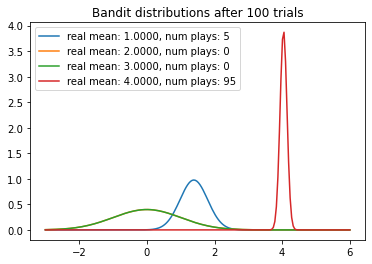

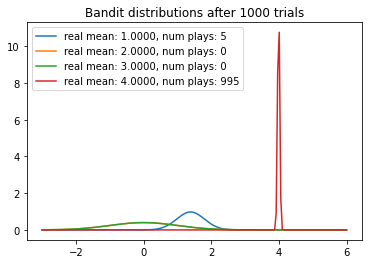

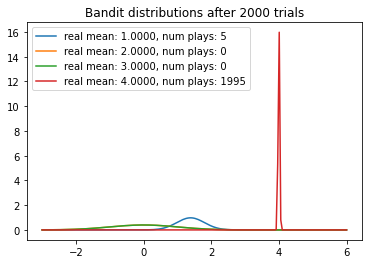

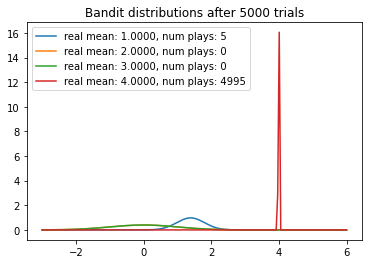

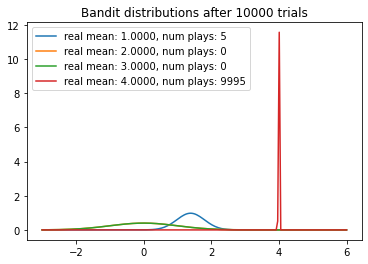

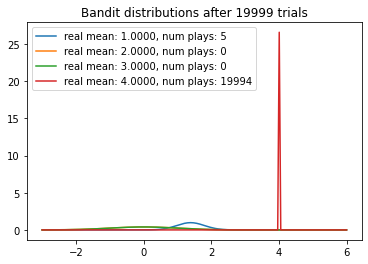

In [11]:
bandits, t_rewards = TS.experiment(BANDIT_REWARD, N=NUMBER_OF_TRIALS)

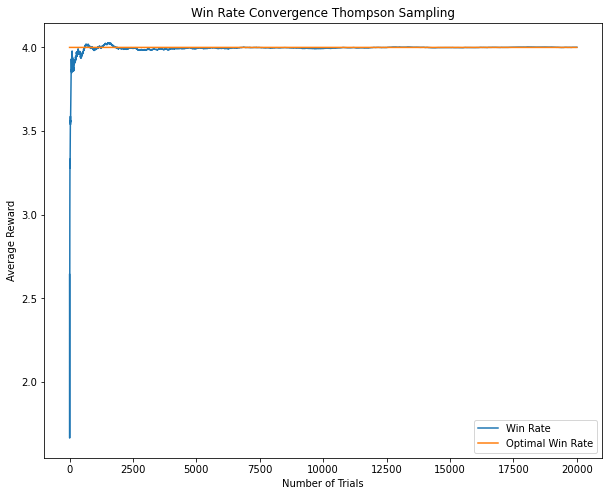

In [12]:
TS.plot_learning_process(BANDIT_REWARD, t_rewards, N=NUMBER_OF_TRIALS)

In [13]:
df = TS.report(bandits, t_rewards, N=NUMBER_OF_TRIALS)

Total Reward Earned: 80020.143973252
Average Reward: 4.0010071986626
Overall Win Rate: 4.0010071986626
Number of times selected each bandit: [5, 0, 0, 19995]


# Comparison

In [14]:
def comparison(epsilon_rewards, thompson_rewards):
    """
    Plot and compare the performance of two algorithms, Epsilon Greedy and Thompson Sampling,
    based on their cumulative rewards and mean reward per trial.
    """
    # Plot cumulative rewards for each algorithm
    plt.figure(figsize=(10, 8))
    plt.plot(epsilon_rewards, label='Epsilon Greedy', alpha=0.75)
    plt.plot(thompson_rewards, label='Thompson Sampling', alpha=0.75)
    plt.title('Comparison of Epsilon Greedy and Thompson Sampling', fontsize=20)
    plt.xlabel('Trial', fontsize=14)
    plt.ylabel('Cumulative Reward', fontsize=14)
    plt.legend()
    plt.show()

    # Plot mean reward per round for each algorithm
    epsilon_mean = [sum(epsilon_rewards[:i+1])/(i+1) for i in range(len(epsilon_rewards))]
    thompson_mean = [sum(thompson_rewards[:i+1])/(i+1) for i in range(len(thompson_rewards))]
    plt.figure(figsize=(10, 8))
    plt.plot(epsilon_mean, label='Epsilon Greedy')
    plt.plot(thompson_mean, label='Thompson Sampling')
    plt.title('Comparison of Epsilon Greedy and Thompson Sampling', fontsize=20)
    plt.xlabel('Trial', fontsize=14)
    plt.ylabel('Mean Reward', fontsize=14)
    plt.legend()
    plt.show()

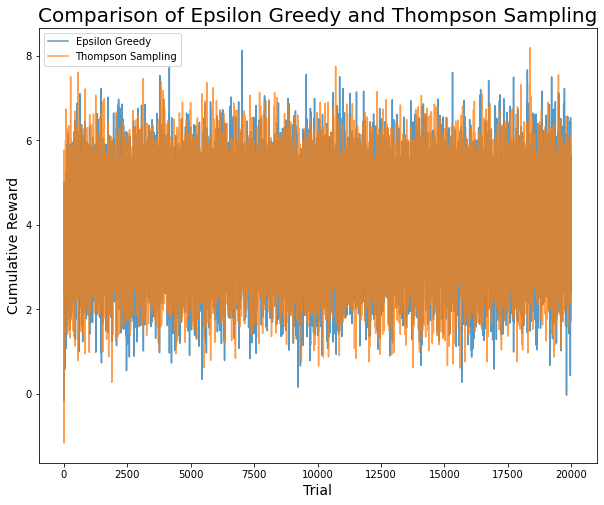

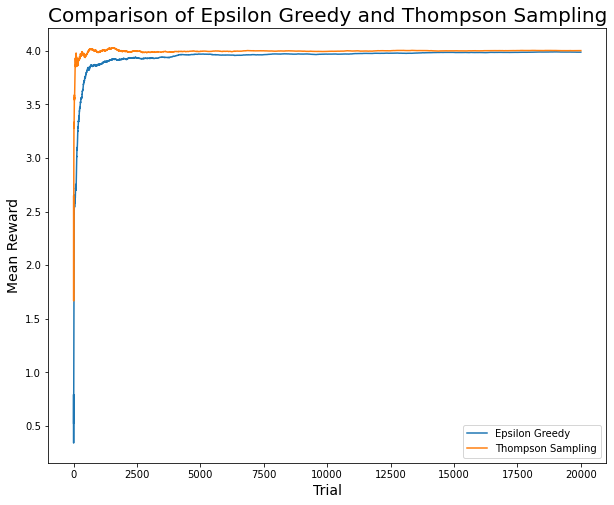

In [15]:
comparison(eg_rewards, t_rewards)

When it comes to choosing between Epsilon Greedy and Thompson Sampling, it ultimately depends on the specific problem and the desired trade-offs between exploration and exploitation. Both algorithms have their strengths and weaknesses, and their performance can vary depending on the specific circumstances.

In general, Epsilon Greedy is a simpler algorithm that is easier to implement and understand, and it can work well when the rewards are relatively consistent and the exploration rate is appropriately tuned. Thompson Sampling, on the other hand, is a more complex algorithm that takes into account uncertainty in the reward distributions, and it can perform better in situations where the rewards are more variable or when there is a high degree of uncertainty in the reward distributions.

Therefore, it is recommended to try both algorithms on a particular problem and evaluate their performance based on the specific criteria and constraints of that problem.